# Benchmarks

## Initialize

In [55]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

In [56]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label = "22_retina_phewas"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

##### BEGIN ADAPT #####
# second best model
# wandb_name = 'aug++_convnext_s_mlp'
# wandb_id = '8ngm6apd'
# best model
wandb_name = 'aug++_convnext_s_mlp+'
wandb_id = '3p3smraz'
partitions = list(0) # list(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22)
##### END   ADAPT #####

experiment = wandb_id
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [57]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [58]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Age+Sex" = colors_dict$pastel$red$mid,
    "Retina" = colors_dict$pastel$red$mid,
    "Age+Sex+Retina" = colors_dict$pastel$red$mid,
    'MultiTaskSurvivalTraining_None_InceptionResnetV2+MLP_Identity' = colors_dict$pastel$red$mid
    #"Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [59]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [60]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [61]:
endpoint_selection = c(
    "phecode_008",
    "phecode_092-2",
    "phecode_105",
    "phecode_107-2",
    "phecode_164",
    "phecode_202-2",
    "phecode_284",
    "phecode_328",
    "phecode_371",
    "phecode_404",
    "phecode_424",
    "phecode_440-11",
    "phecode_468",
    "phecode_474",
    "phecode_522-1",
    "phecode_542-1",
    "phecode_581-1",
    "phecode_583",
    "phecode_705-1",
    "OMOP_4306655"
    )

In [62]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>% 
    mutate(name = 
           case_when( 
               endpoint == "phecode_092-2"~"Sepsis", 
               #endpoint == "phecode_105"~"Malign breast cancer", 
               endpoint == "phecode_123"~"Malignant plasma cell neoplasms", 
               endpoint == "phecode_164"~"Anemia", 
               endpoint == "phecode_200-1"~"Hypothyroidism", 
               endpoint == "phecode_232"~"Vitamin deficiencies", 
               endpoint == "phecode_284"~"Suicide attempt or self harm", 
               #endpoint == "phecode_287-5"~"Drug-induced psychosis", 
               #endpoint == "phecode_328"~"Dementia", 
               #endpoint == "phecode_404"~"Coronary heart disease", 
               endpoint == "phecode_424"~"Heart failure", 
               endpoint == "phecode_440-11"~"Deep vein thrombosis", 
               endpoint == "phecode_468"~"Pneumonia", 
               endpoint == "phecode_474"~"COPD", 
               endpoint == "phecode_518"~"Appendicitis", 
               endpoint == "phecode_542-1"~"Fibrosis and cirrhosis of liver", 
               endpoint == "phecode_583"~"Chronic kidney disease", 
               endpoint == "phecode_705-1"~"Rheumatoid arthritis", 
               endpoint == "phecode_908-1"~"(Pre)eclampsia", 
               #endpoint == "phecode_976"~"Complication of anesthesia",
               TRUE ~ name)
           )

endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

## Load data

# Load Benchmarks

In [63]:
today = substr(Sys.time(), 0, 10) # YYYY-MM-DD

In [64]:
name = glue("benchmark_cindex_agesexcoxph_{today}")
benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoint_defs) 

Joining, by = "endpoint"



In [65]:
benchmark_endpoints %>% group_by(endpoint, score)  %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



score,mean(cindex)
<chr>,<dbl>
Retina,0.5483485
Age+Sex,0.5928939
Age+Sex+Retina,0.5976983


In [66]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [67]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can override using the `.groups` argument.



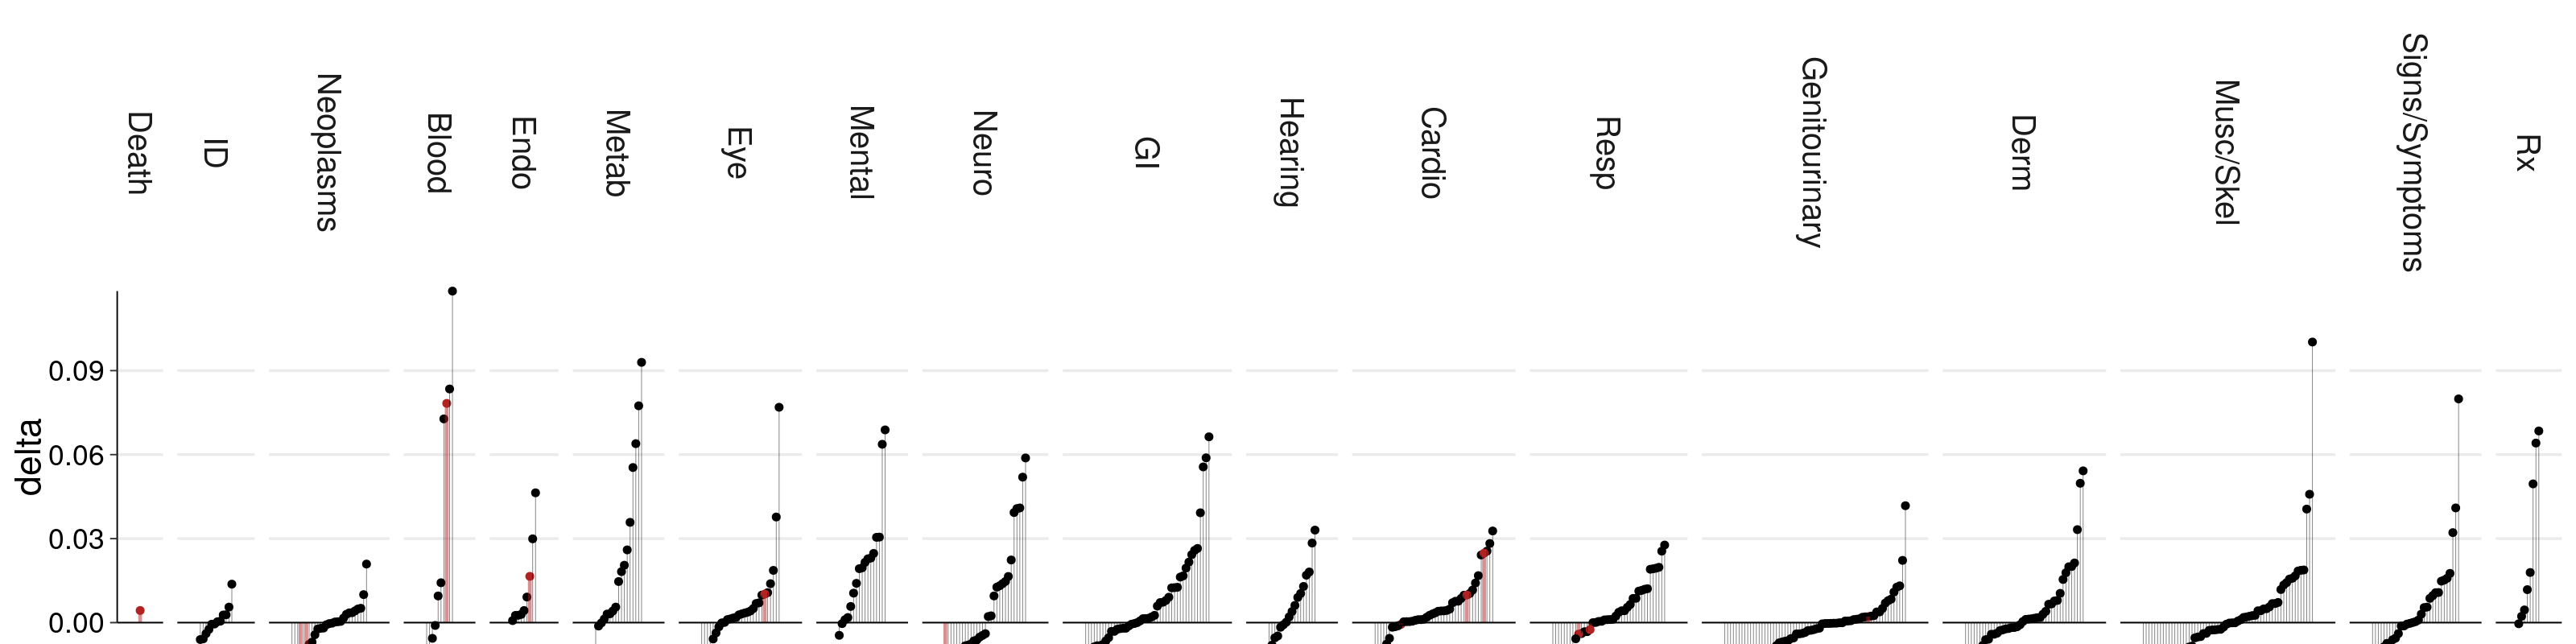

In [68]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp %>% arrange(delta))$endpoint

temp = temp %>% mutate(endpoint = factor(endpoint, levels=endpoint_order))

ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

In [69]:
plot_width = 8.25; plot_height=2; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Retina", "Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #mutate(delta_int = `Age+Sex+Retina`-`Age+Sex+Retina`) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%
    filter(endpoint %in% endpoint_selection)
    #%>%
    #summarise(cindex = mean(cindex)) 
temp

endpoint,iteration,time,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name,Age+Sex,Retina,Age+Sex+Retina,id,delta,pos,highlight
<fct>,<int>,<int>,<chr>,<chr>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
OMOP_4306655,0,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6379269,0.6344823,0.6452410,1,0.0073140841,pos,YES
OMOP_4306655,1,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6726924,0.6649550,0.6790557,2,0.0063633064,pos,YES
OMOP_4306655,2,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6839902,0.6747696,0.6900699,3,0.0060797031,pos,YES
OMOP_4306655,3,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6714327,0.6614982,0.6764444,4,0.0050116393,pos,YES
OMOP_4306655,4,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6754350,0.6810285,0.6894536,5,0.0140186287,pos,YES
OMOP_4306655,5,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6711791,0.6581261,0.6742333,6,0.0030541723,pos,YES
OMOP_4306655,6,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6707202,0.6608689,0.6759391,7,0.0052189256,pos,YES
OMOP_4306655,7,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6468938,0.6522939,0.6600056,8,0.0131117703,pos,YES
OMOP_4306655,8,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.6773633,0.6665864,0.6821743,9,0.0048109042,pos,YES


In [70]:
library(ggdist)

In [71]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



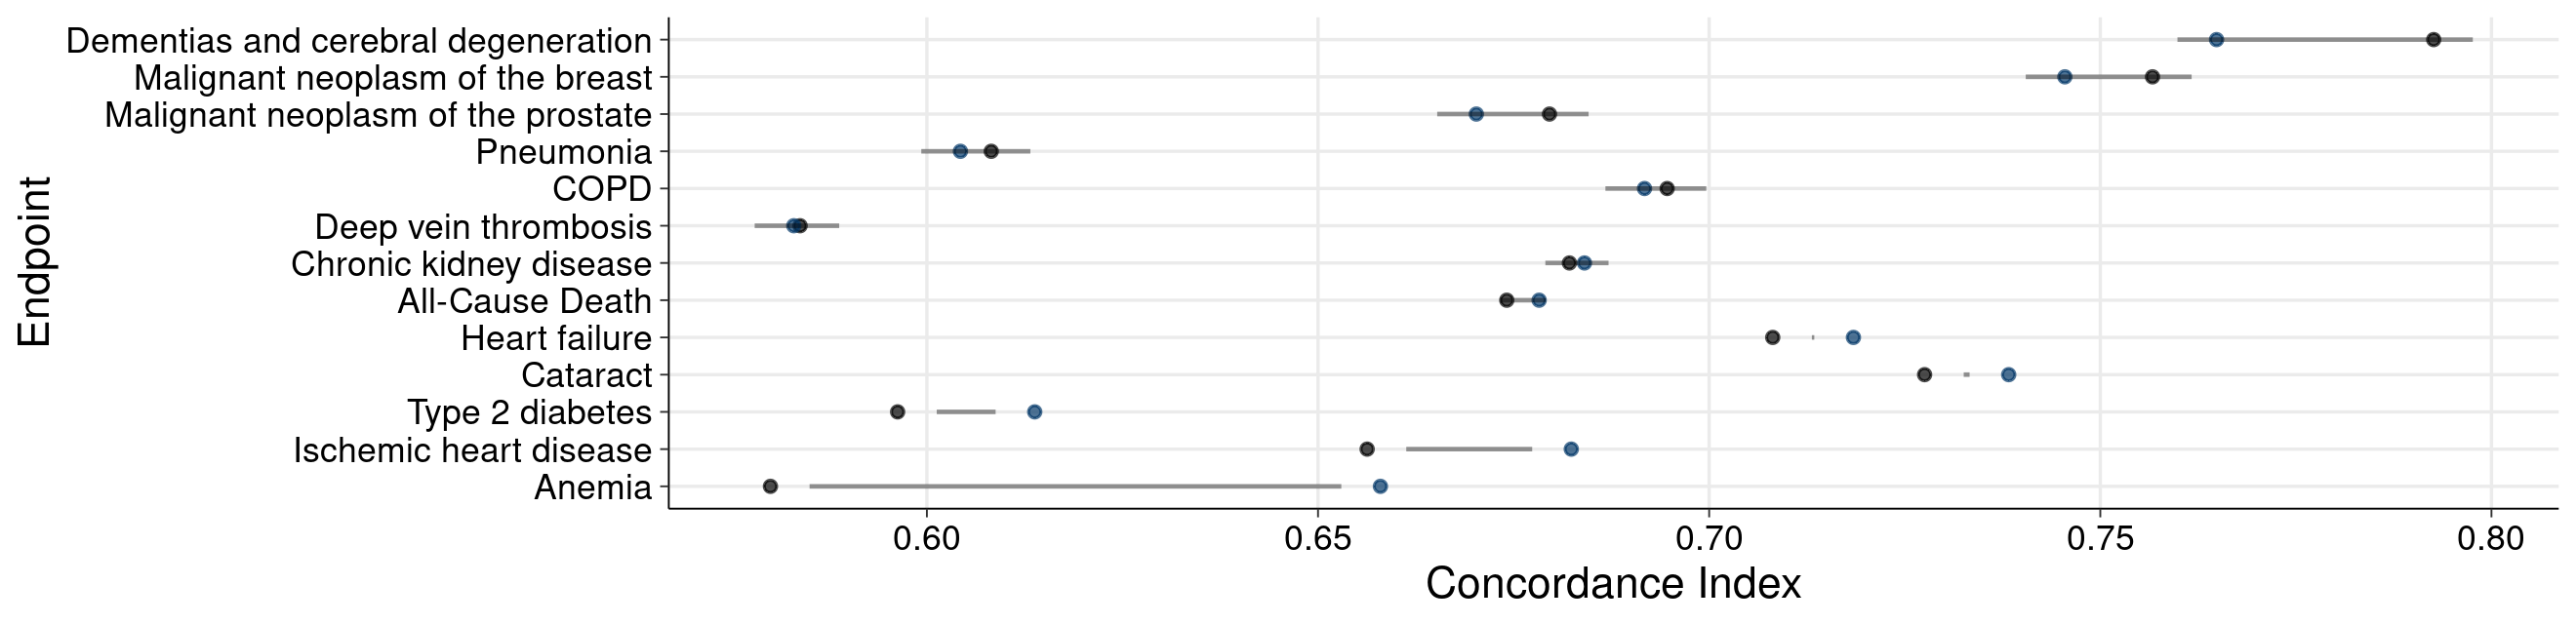

In [72]:
abs = ggplot(temp %>% group_by(endpoint) %>% summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`))) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Concordance Index", x="Endpoint")+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex`), size=1, color="black", alpha=0.3)+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex+Retina`), size=1, color="#023768", alpha=0.5)+
    geom_point(aes(x=fct_rev(endpoint), y=m_as), size=1, color="black", alpha=0.7)+
    geom_point(aes(x=fct_rev(endpoint), y=m_asm), size=1, color="#023768", alpha=0.7)+
    geom_segment(aes(x=endpoint, xend=endpoint, y=m_as+0.005, yend=m_asm-0.005), alpha=0.4)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_x_discrete(labels=endpoint_map) +
    #scale_y_continuous(expand=c(0, 0))+
    #theme(axis.title.x=element_blank(),
     #   axis.text.x=element_blank(),
      #  axis.ticks.x=element_blank(),
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)
abs 

In [73]:
rel = ggplot(temp) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Difference in Concordance Index")+
    stat_pointinterval(aes(x=fct_rev(endpoint), y=delta), size=0.5)+
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    #scale_y_continuous(expand=c(0, 0))+
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
       axis.ticks.y=element_blank()) + 
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



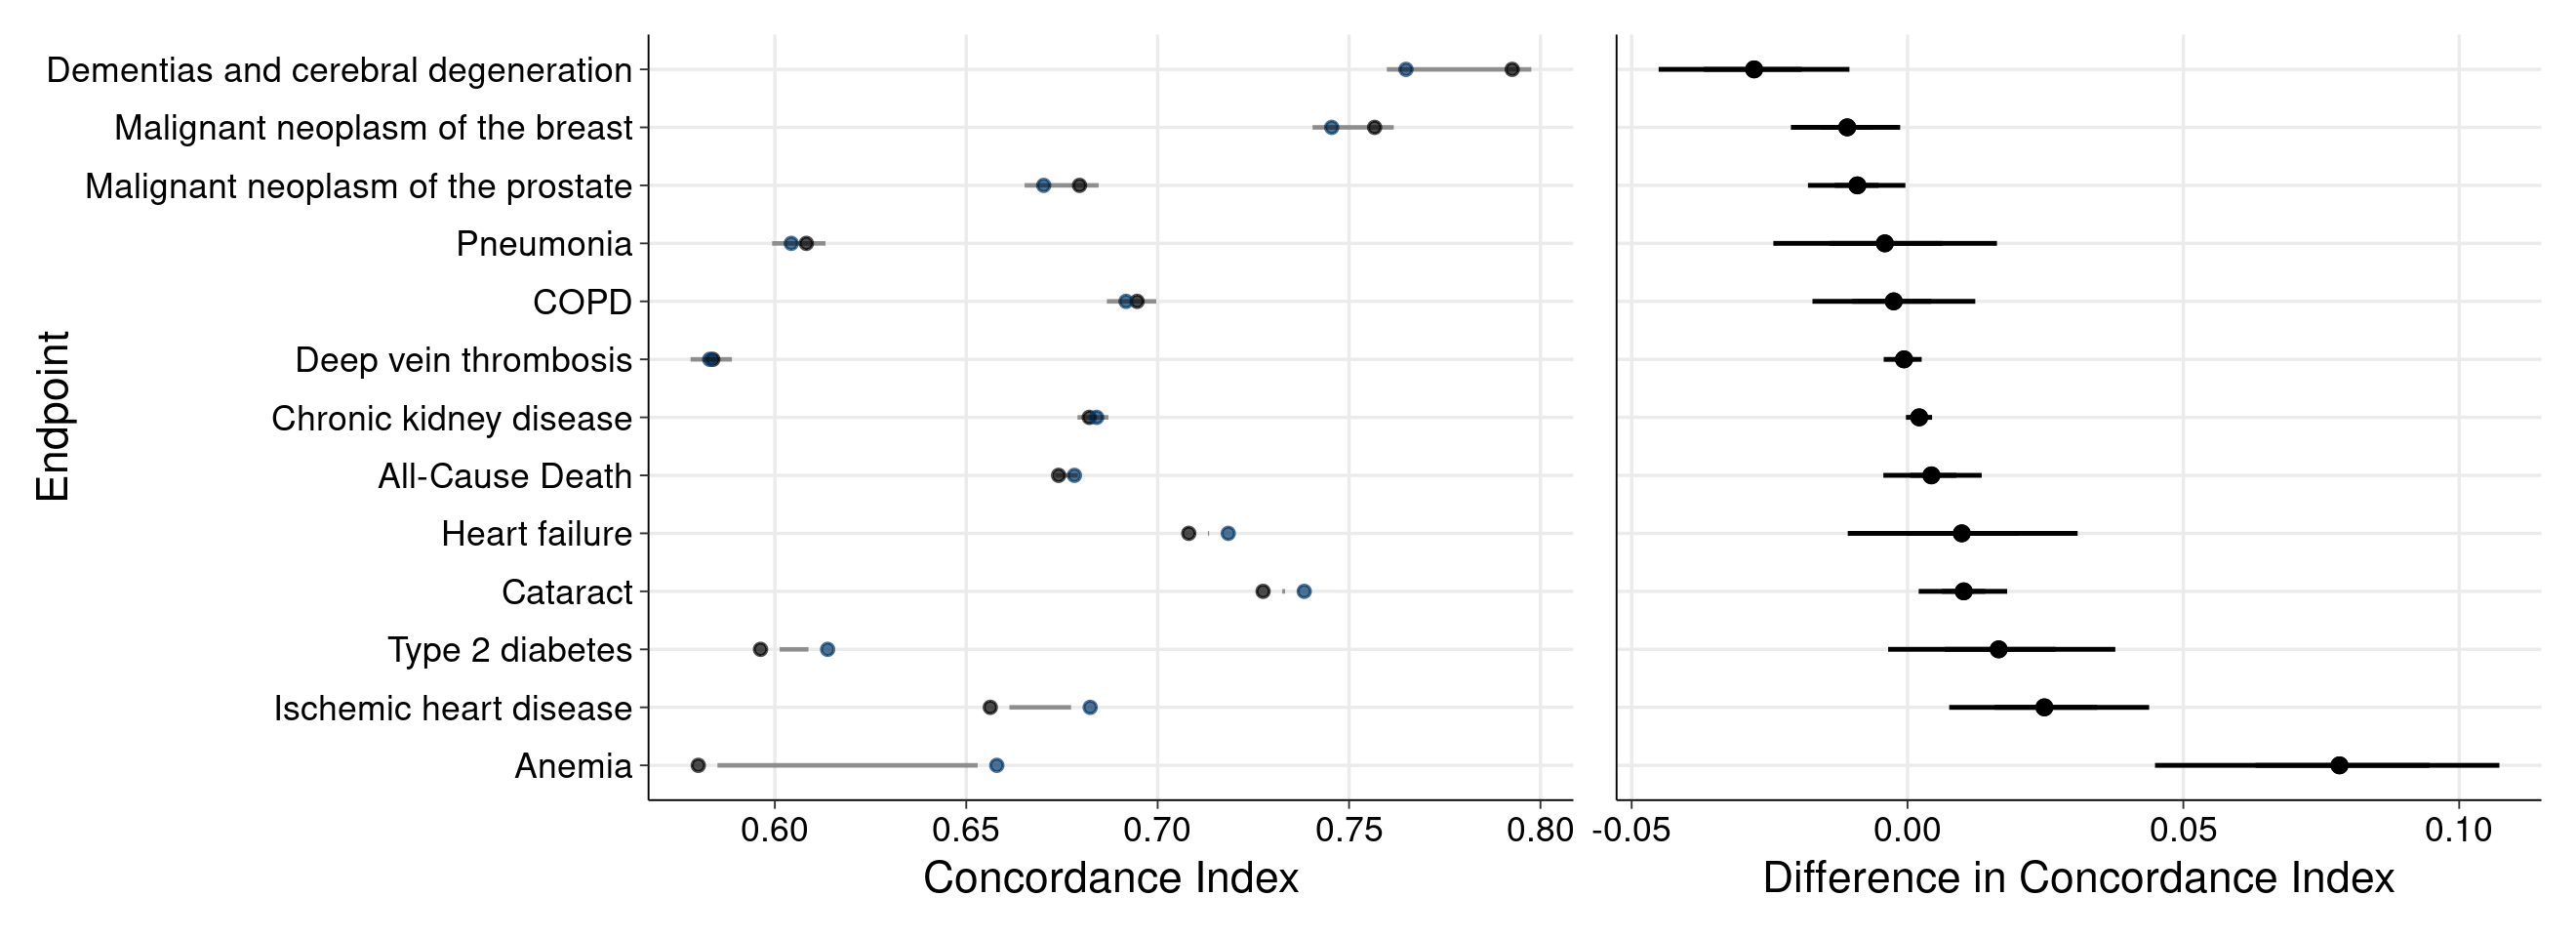

In [74]:
plot_width = 8.25; plot_height=3; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
abs|rel

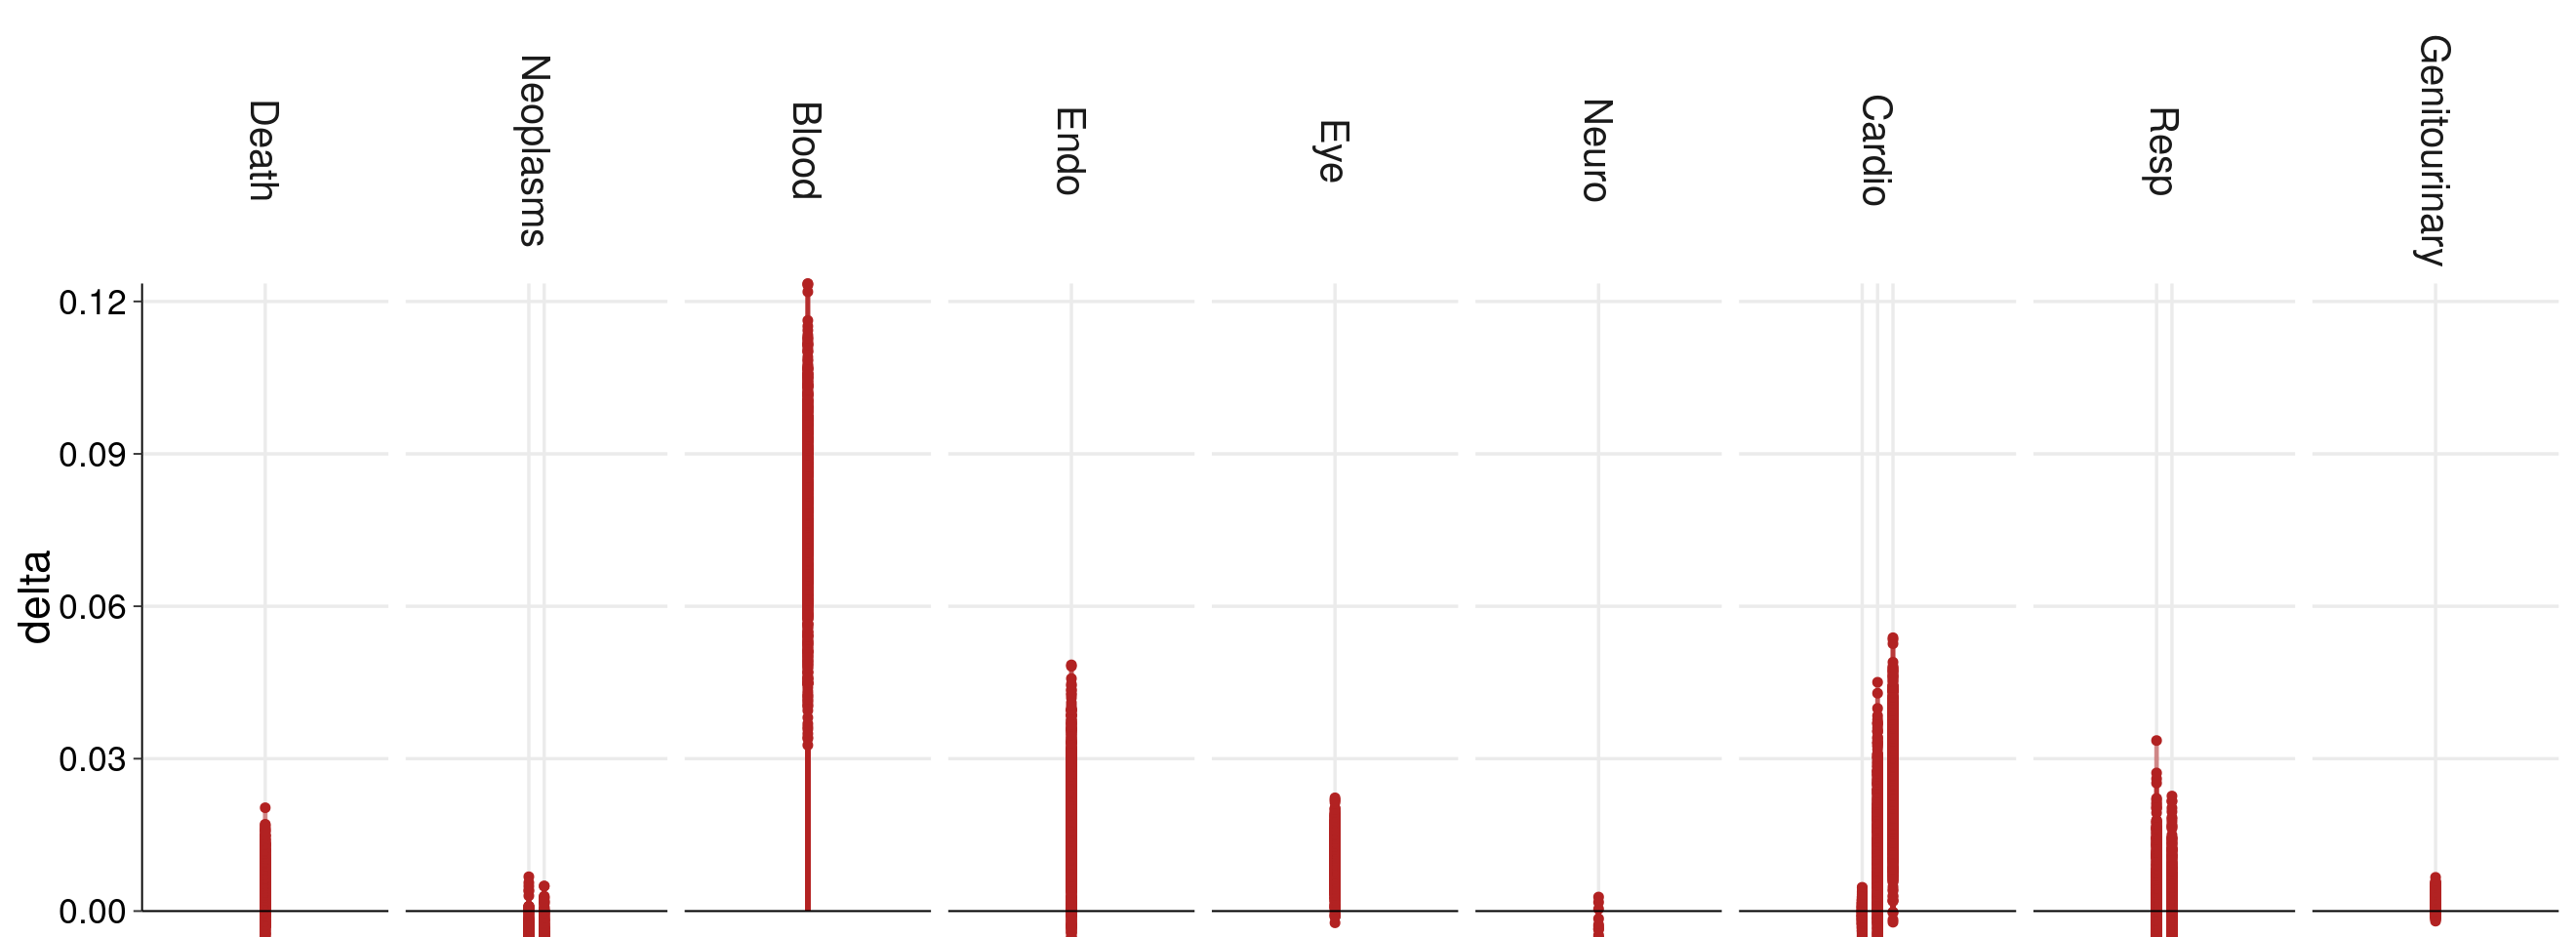

In [75]:
ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

In [76]:
library(ggdist)

In [77]:
table_2 = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+Retina`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>%
    #ungroup() %>%
    mutate(agg = glue("{round(cindex, 3)} ({round(.lower, 3)}, {round(.upper, 3)})")) %>%
    ungroup() %>% select(endpoint, phecode_string, phecode_category, type, agg) %>%
    pivot_wider(names_from=type, values_from=agg)
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    #mutate(endpoint = fct_reorder(endpoint, delta))# %>% filter(endpoint %in% endpoint_sample)

In [78]:
table_2 %>% 
    select(all_of(c("endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint)

endpoint,phecode_string,Age+Sex,Age+Sex+Retina,delta
<fct>,<chr>,<glue>,<glue>,<glue>
phecode_328,Dementias and cerebral degeneration,"0.793 (0.759, 0.827)","0.765 (0.732, 0.799)","-0.028 (-0.045, -0.011)"
phecode_105,Malignant neoplasm of the breast,"0.757 (0.732, 0.778)","0.745 (0.721, 0.767)","-0.011 (-0.021, -0.001)"
phecode_107-2,Malignant neoplasm of the prostate,"0.68 (0.649, 0.709)","0.67 (0.641, 0.702)","-0.009 (-0.018, 0)"
phecode_468,Pneumonia,"0.608 (0.565, 0.653)","0.604 (0.558, 0.651)","-0.004 (-0.024, 0.016)"
phecode_474,Chronic obstructive pulmonary disease [COPD],"0.695 (0.665, 0.724)","0.692 (0.663, 0.723)","-0.002 (-0.017, 0.012)"
phecode_440-11,Deep vein thrombosis [DVT],"0.584 (0.52, 0.645)","0.583 (0.52, 0.645)","-0.001 (-0.004, 0.003)"
phecode_583,Chronic kidney disease,"0.682 (0.652, 0.71)","0.684 (0.653, 0.712)","0.002 (0, 0.004)"
OMOP_4306655,All-Cause Death,"0.674 (0.65, 0.698)","0.678 (0.655, 0.703)","0.004 (-0.004, 0.013)"
phecode_424,Heart failure,"0.708 (0.66, 0.759)","0.718 (0.67, 0.768)","0.01 (-0.011, 0.031)"


In [79]:
options(pillar.print_max = Inf)
table_2 %>% 
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    #filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    write_csv("outputs/SupplTable1_DiscriminativePerformanceAll.csv")

In [80]:
table_2 %>% filter(endpoint %in% endpoint_selection) %>% arrange(as.character(endpoint))

endpoint,phecode_string,phecode_category,Age+Sex,Age+Sex+Retina,delta
<fct>,<chr>,<chr>,<glue>,<glue>,<glue>
OMOP_4306655,All-Cause Death,Death,"0.674 (0.65, 0.698)","0.678 (0.655, 0.703)","0.004 (-0.004, 0.013)"
phecode_105,Malignant neoplasm of the breast,Neoplasms,"0.757 (0.732, 0.778)","0.745 (0.721, 0.767)","-0.011 (-0.021, -0.001)"
phecode_107-2,Malignant neoplasm of the prostate,Neoplasms,"0.68 (0.649, 0.709)","0.67 (0.641, 0.702)","-0.009 (-0.018, 0)"
phecode_164,Anemia,Blood,"0.58 (0.549, 0.61)","0.658 (0.631, 0.686)","0.078 (0.045, 0.107)"
phecode_202-2,Type 2 diabetes,Endo,"0.596 (0.573, 0.62)","0.614 (0.591, 0.636)","0.017 (-0.004, 0.038)"
phecode_328,Dementias and cerebral degeneration,Neuro,"0.793 (0.759, 0.827)","0.765 (0.732, 0.799)","-0.028 (-0.045, -0.011)"
phecode_371,Cataract,Eye,"0.728 (0.709, 0.748)","0.738 (0.721, 0.757)","0.01 (0.002, 0.018)"
phecode_404,Ischemic heart disease,Cardio,"0.656 (0.627, 0.687)","0.682 (0.654, 0.711)","0.025 (0.008, 0.044)"
phecode_424,Heart failure,Cardio,"0.708 (0.66, 0.759)","0.718 (0.67, 0.768)","0.01 (-0.011, 0.031)"
